# Variance Comparisons

The following codes generate the figures shown in my lab seminar presentation.

In [119]:
library(dplyr)
library(rstan)
library(ggplot2)
library(gridExtra)
library(xtable)

options(repr.plot.width = 10, repr.plot.height = 7)

source("bbvi_simplemix.R")

## Variance Comparisons Between Naive, Rao-Blackwellized, and James-Stein Estimators

We will be performing the estimation repeatedly, to get a controlled Monte Carlo sample of the inherent variances in the estimators being compared.

**Don't Run The Next Cell Unless Updating Results** Total expected run is at 3000 min.

In [123]:
niter <- 100
sampsize <- 200
mc_size <- 500

all_means <- -5:5
all_vars <- rep(3, times = length(all_means))

In [129]:
all.variances <- NULL
all.iterations <- list(10)

for(seed in 0:9){
    set.seed(seed)

    for(K in 2:10){
        d <- generate_mixture(sampsize, runif(K), means=all_means[1:K], vars=all_vars[1:K])$samp

        phi <- t(sapply(d, function(x){
            y <- runif(K)
            return(y/sum(y))
        }))

        m <- all_means[1:K] + 1
        iters <- list(niter)
        for(i in 1:niter){
            if(i %% 50 == 0) message(paste0("Mixture Components: ", K, "; Iteration: ", i, "/", niter))
            
            dat.nav <- generate_samples(mc_size, y = d, phi = phi, m=m, ssq=all_vars[1:K], method="Naive")
            dat.rbl <- generate_samples(mc_size, y = d, phi = phi, m=m, ssq=all_vars[1:K], method="RB")
            dat.jsp <- generate_samples(mc_size, y = d, phi = phi, m=m, ssq=all_vars[1:K], method="JS+")
            dat.rbp <- generate_samples(mc_size, y = d, phi = phi, m=m, ssq=all_vars[1:K], method="RB+")

            iters[[i]] <- rbind(
                cbind(method="Naive", iter=i, generate_bbvi(dat.nav)),
                cbind(method="RB", iter=i, generate_bbvi(dat.rbl)),
                cbind(method="JS+", iter=i, generate_bbvi(dat.jsp)),
                cbind(method="RB+", iter=i, generate_bbvi(dat.rbp))
            )
        }

        mse <- do.call('rbind',iters)
        if(K == 3) all.iterations[[seed+1]] <- mse # save this

        par.variances <- aggregate(mse[,4:ncol(mse)], by=list(method=mse$method, param=mse$param), var)
        for(method in c("Naive","RB","JS+","RB+")){
            this.method <- par.variances[par.variances$method == method,3:ncol(par.variances)]
            all.variances <- rbind(all.variances,
                data.frame(K=K, method=method,logVar=log(mean(as.matrix(this.method)))))
        }
    }

}

saveRDS(all.variances, "Outputs/all_variances.RDS")
saveRDS(mse, "Outputs/last_iteration.RDS")

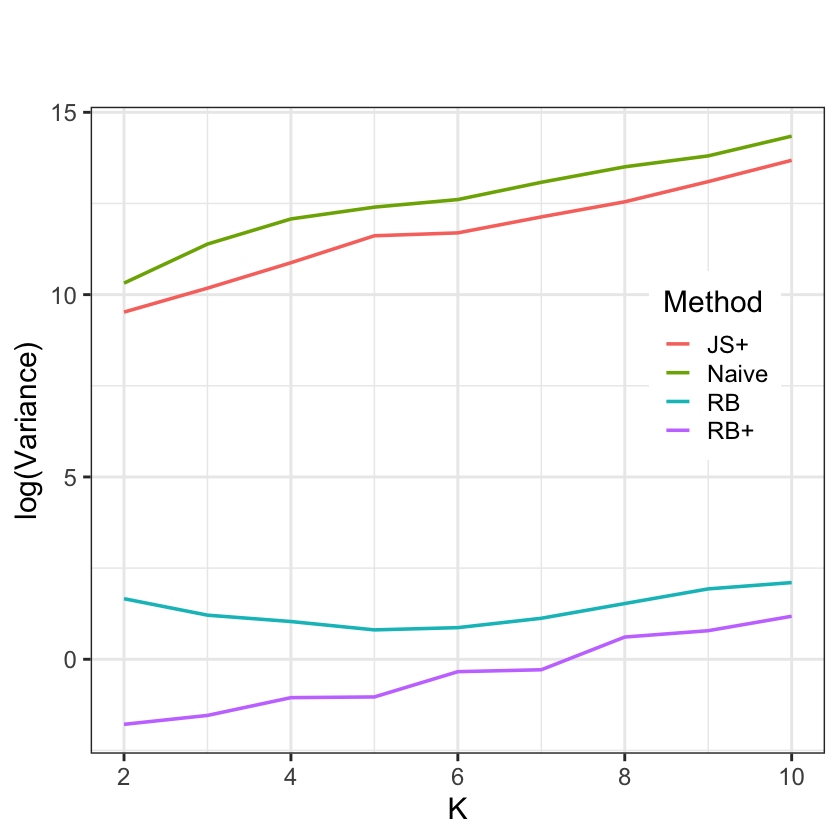

In [65]:
all.variances <- readRDS("Outputs/all_variances.RDS")

p1 <- all.variances %>%
    ggplot(aes(x=K, y=logVar, color=method)) +
    geom_line(linewidth=1) + 
    labs(title = "", subtitle = "", x = "K", y = "log(Variance)") +
    scale_color_discrete(name = "Method") +
    theme_bw(base_size=18) +
    theme(legend.position = c(0.85, 0.60))

options(repr.plot.width = 7, repr.plot.height = 7)
p1

In [4]:
all.efficiencies <- NULL
for(k in 2:6){
    this.var <- all.variances[all.variances$K == k, ]
    this.var$Var <- exp(this.var$logVar)
    this.var$Eff <- 1
    this.var$Eff[2:4] <- 100 * this.var$Var[2:4]/this.var$Var[1]
    all.efficiencies <- rbind(all.efficiencies, this.var)
}

all.efficiencies %>%
    mutate(Var = round(Var, 2), Eff = round(Eff,2)) %>%
    select(K, method, Var, Eff)

,K,method,Var,Eff
,<int>,<chr>,<dbl>,<dbl>
1,2,Naive,30197.20,1.00
2,2,RB,5.27,0.02
3,2,JS+,13644.93,45.19
4,2,RB+,0.17,0.00
5,3,Naive,88114.87,1.00
6,3,RB,3.35,0.00
7,3,JS+,26303.45,29.85
8,3,RB+,0.21,0.00
9,4,Naive,175569.35,1.00


## Using The BBVI Algorithm

This time we create the BBVI Algorithm In A Sample Dataset with K = 3 Components.

In [120]:
set.seed(923)
samp.dat <- generate_mixture(sampsize, runif(2), means=all_means[1:2], vars=all_vars[1:2])

In [107]:
samp.nav <- simplemix.bbvi(samp.dat$samp, K = 2, maxiter = 50, learn_rate = rate_constant(1e-3), mc_size = 100, method = "Naive", verbose = TRUE)
samp.rbl <- simplemix.bbvi(samp.dat$samp, K = 2, maxiter = 50, learn_rate = rate_constant(1e-3), mc_size = 100, method = "RB", verbose = TRUE)
samp.jsp <- simplemix.bbvi(samp.dat$samp, K = 2, maxiter = 50, learn_rate = rate_constant(1e-3), mc_size = 100, method = "JS+", verbose = TRUE)
samp.rbp <- simplemix.bbvi(samp.dat$samp, K = 2, maxiter = 50, learn_rate = rate_constant(1e-2), mc_size = 100, method = "RB+", verbose = TRUE)

Doing Black Box Variational Inference With Method Naive

Doing Black Box Variational Inference With Method RB

Doing Black Box Variational Inference With Method JS+

Doing Black Box Variational Inference With Method RB+



Warning message:
"Removed 42 rows containing missing values (`geom_line()`)."


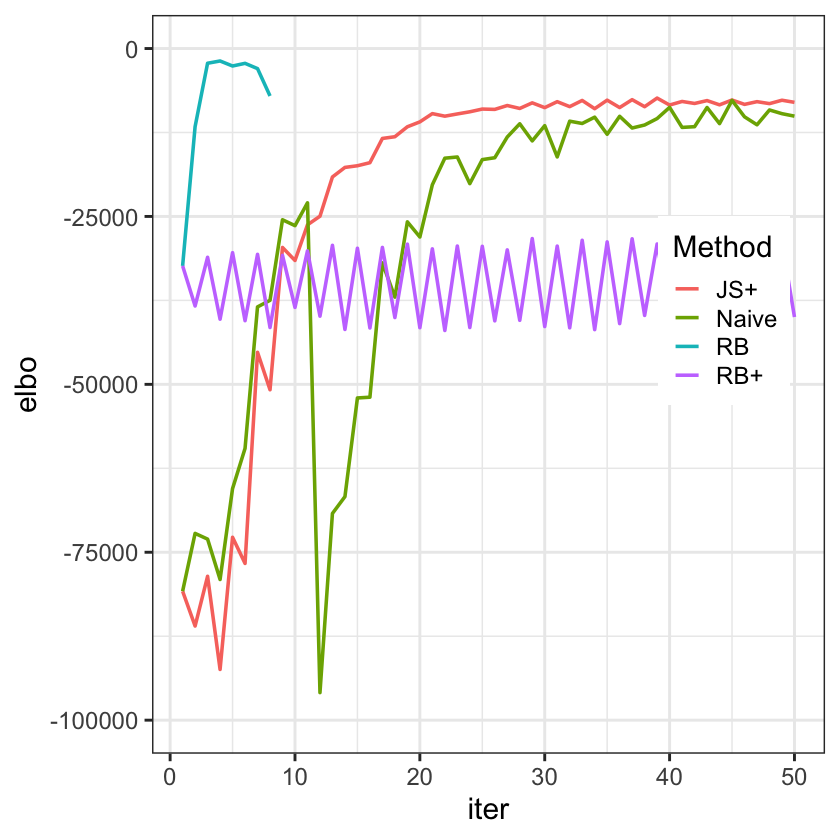

In [113]:
p2 <- bind_rows(
    samp.nav$elbo %>% mutate(method = "Naive"),
    samp.rbl$elbo %>% mutate(method = "RB"),
    samp.jsp$elbo %>% mutate(method = "JS+"),
    samp.rbp$elbo %>% mutate(method = "RB+")
) %>%
    ggplot(aes(x = iter, y = elbo, color = method)) + 
    geom_line(linewidth = 1) + 
    scale_y_continuous(limits = c(-1e05, 0e00)) +
    scale_color_discrete(name = "Method") +
    theme_bw(base_size=18) +
    theme(legend.position = c(0.85, 0.60))

options(repr.plot.width = 7, repr.plot.height = 7)
p2

Warning message:
"Removed 4 rows containing missing values (`geom_line()`)."


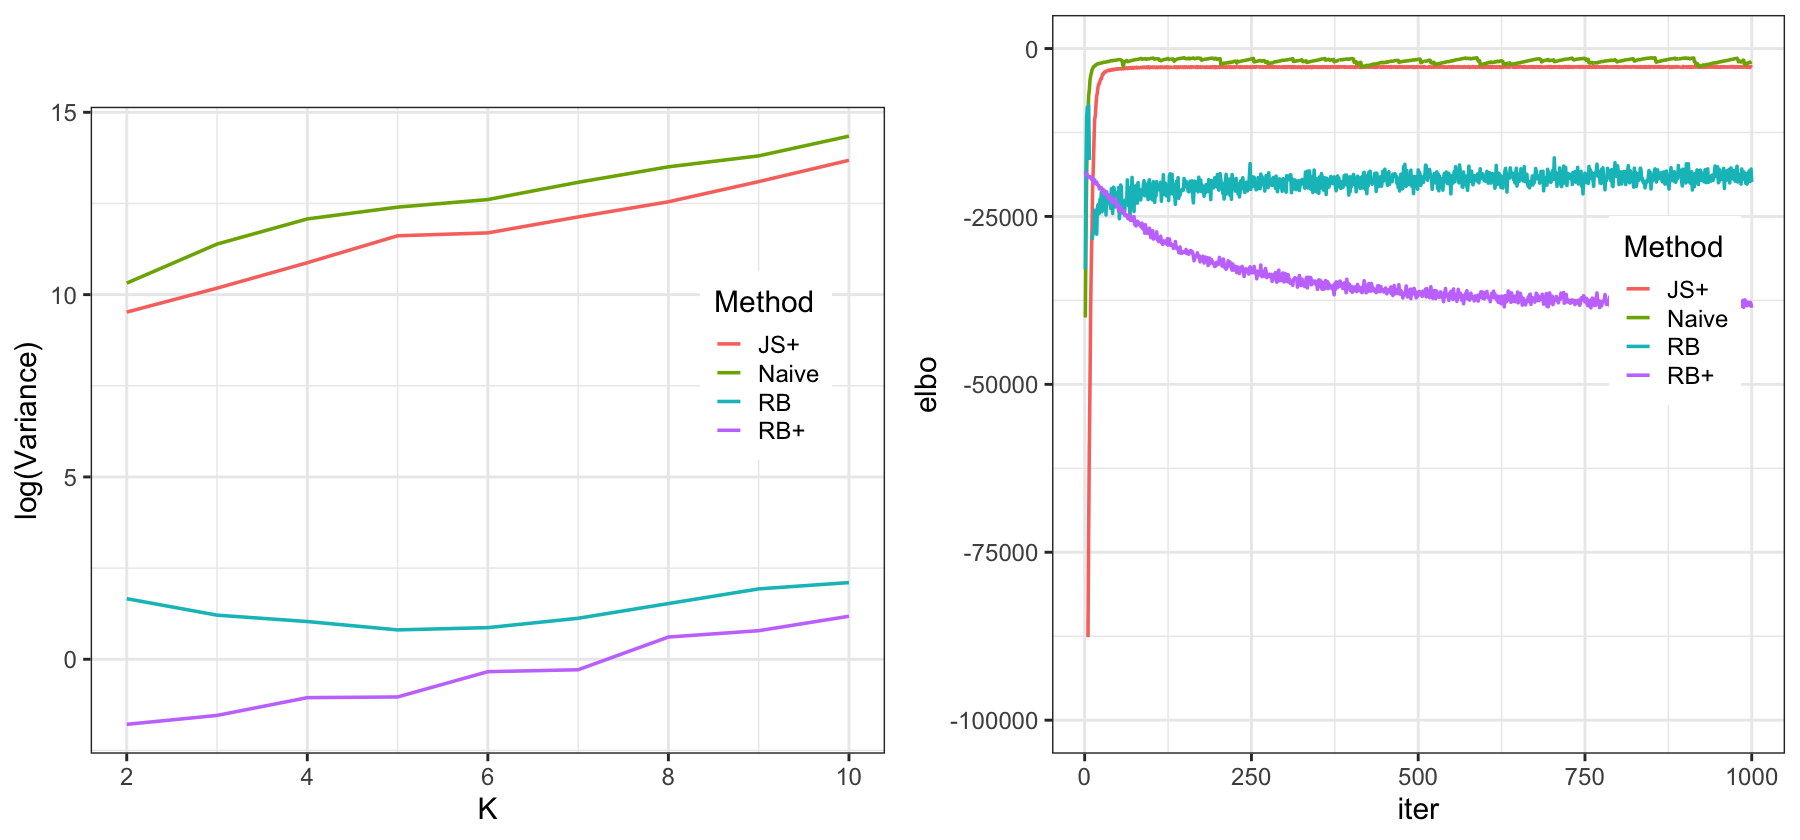

In [82]:
options(repr.plot.width = 15, repr.plot.height = 7)
grid.arrange(p1, p2, nrow = 1)

In [110]:
means <- bind_rows(
    samp.nav$paths %>% filter(param == "m") %>% mutate(method = "Naive"),
    samp.rbl$paths %>% filter(param == "m") %>% mutate(method = "RB"),
    samp.jsp$paths %>% filter(param == "m") %>% mutate(method = "JS+"),
    samp.rbp$paths %>% filter(param == "m") %>% mutate(method = "RB+")
) 

p3 <- means %>%
    ggplot(aes(x = iter, y = X1, color = method)) +
    geom_line(linewidth = 1) + 
    geom_line(aes(y = all_means[1]), linetype="dashed", linewidth = 1, color = "grey")

p4 <- means %>%
    ggplot(aes(x = iter, y = X2, color = method)) +
    geom_line() + 
    geom_line(aes(y = all_means[2]), linetype="dashed", linewidth = 1, color = "grey") +
    facet_wrap(~method)

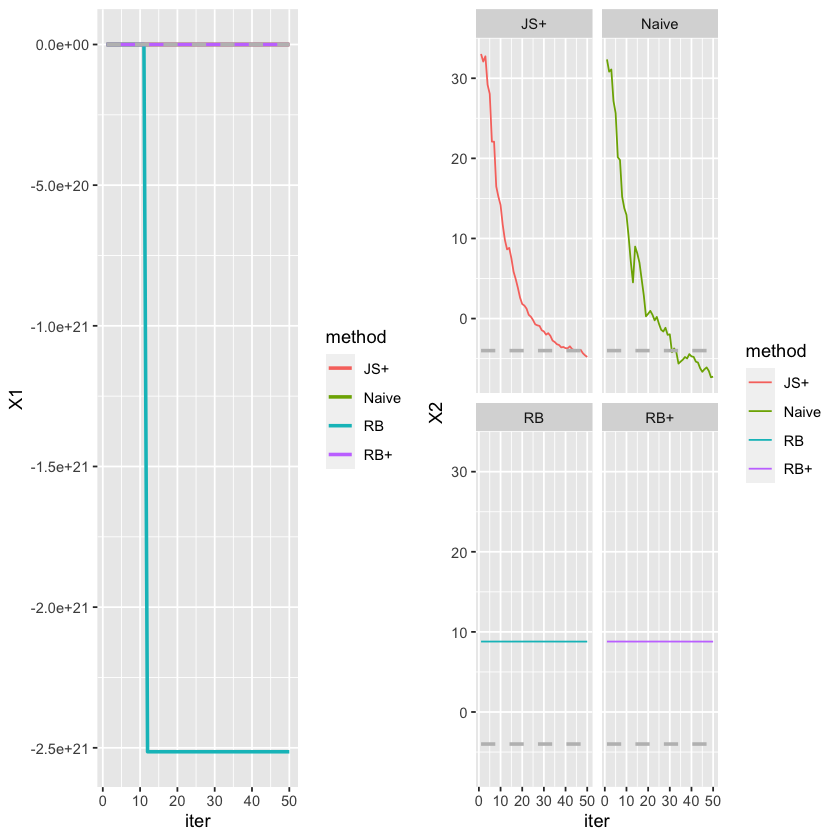

In [111]:
grid.arrange(p3, p4, nrow = 1)

## Constant, Reciprocal, AdaGrad, and RMSProp Learning Rates

This time we focus on BBVI-JS+ and compare its performance when performing estimation using a constant, reciprocal, agadrad, and rmsprop learning rates.

In [115]:
jsp.const <- simplemix.bbvi(samp.dat$samp, K = 3, maxiter = 100, learn_rate = rate_constant(1e-3), mc_size = 500, method = "JS+", verbose = TRUE)
jsp.recip <- simplemix.bbvi(samp.dat$samp, K = 3, maxiter = 100, learn_rate = rate_reciprocal(1e-3), mc_size = 500, method = "JS+", verbose = TRUE)
jsp.adagd <- simplemix.bbvi(samp.dat$samp, K = 3, maxiter = 100, learn_rate = rate_adagrad(1), mc_size = 500, method = "JS+", beta = NULL, verbose = TRUE)
jsp.rmspp <- simplemix.bbvi(samp.dat$samp, K = 3, maxiter = 100, learn_rate = rate_adagrad(1), mc_size = 500, method = "JS+", beta = 0.9, verbose = TRUE)

Doing Black Box Variational Inference With Method JS+

BBVI-JS+: Iteration 100 | Means at -4.73, -4.47 | Variances at 1.68, 0.65 | ELBO: -831.81

BBVI-JS+: Iteration 200 | Means at -4.75, -4.47 | Variances at 0.78, 0.64 | ELBO: -710.65

BBVI-JS+: Iteration 300 | Means at -4.75, -4.47 | Variances at 0.72, 0.63 | ELBO: -709.08

BBVI-JS+: Iteration 400 | Means at -4.75, -4.47 | Variances at 0.66, 0.61 | ELBO: -700.92

BBVI-JS+: Iteration 500 | Means at -4.75, -4.47 | Variances at 0.74, 0.59 | ELBO: -701.56

Doing Black Box Variational Inference With Method JS+

BBVI-JS+: Iteration 100 | Means at 0.91, 6.43 | Variances at 2.8, 4.64 | ELBO: -7791.53

BBVI-JS+: Iteration 200 | Means at 0.76, 6.04 | Variances at 2.79, 4.61 | ELBO: -7491.42

BBVI-JS+: Iteration 300 | Means at 0.66, 5.82 | Variances at 2.77, 4.6 | ELBO: -7038.24

BBVI-JS+: Iteration 400 | Means at 0.6, 5.67 | Variances at 2.76, 4.59 | ELBO: -6856.64

BBVI-JS+: Iteration 500 | Means at 0.56, 5.55 | Variances at 2.75, 4.58 | ELBO

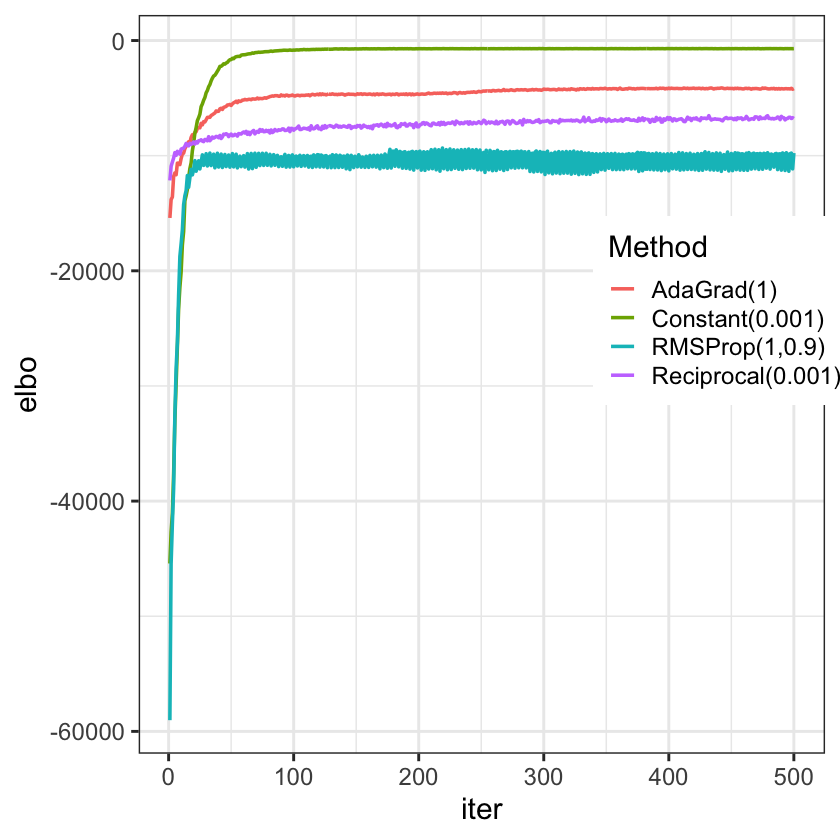

In [117]:
p6 <- bind_rows(
    jsp.const$elbo %>% mutate(method = "Constant(0.001)"),
    jsp.recip$elbo %>% mutate(method = "Reciprocal(0.001)"),
    jsp.adagd$elbo %>% mutate(method = "AdaGrad(1)"),
    jsp.rmspp$elbo %>% mutate(method = "RMSProp(1,0.9)")
) %>%
    ggplot(aes(x = iter, y = elbo, color = method)) + 
    geom_line(linewidth = 1) + 
    scale_y_continuous() +
    scale_color_discrete(name = "Method") +
    theme_bw(base_size=18) +
    theme(legend.position = c(0.85, 0.60))


options(repr.plot.width = 7, repr.plot.height = 7)
p6

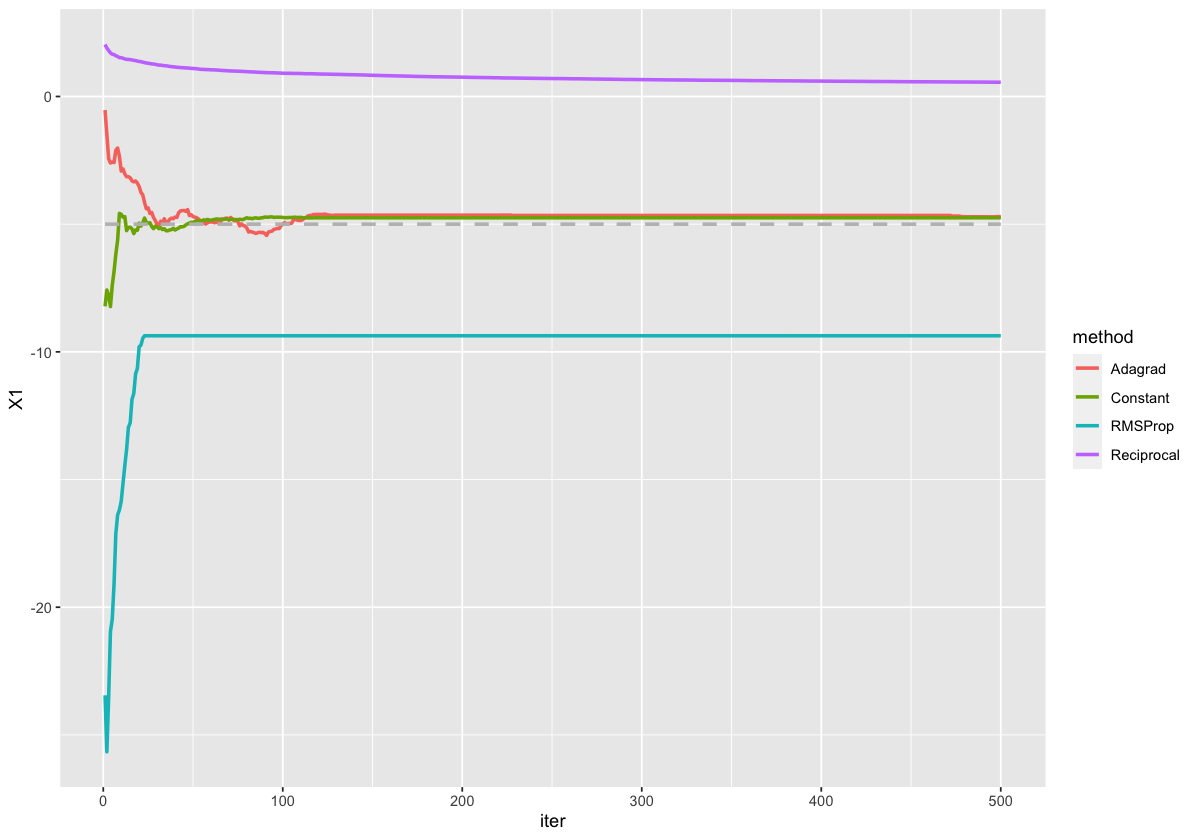

In [122]:
bind_rows(
    jsp.const$paths %>% filter(param == "m") %>% mutate(method = "Constant"),
    jsp.recip$paths %>% filter(param == "m") %>% mutate(method = "Reciprocal"),
    jsp.adagd$paths %>% filter(param == "m") %>% mutate(method = "Adagrad"),
    jsp.rmspp$paths %>% filter(param == "m") %>% mutate(method = "RMSProp")
) %>%
    ggplot(aes(x = iter, y = X1, color = method)) +
    geom_line(linewidth = 1) + 
    geom_line(aes(y = all_means[1]), linetype="dashed", linewidth = 1, color = "grey")

## Plots Appearing In Paper

The following generates the plots that appear in the paper